In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

## Util functions

In [2]:
def set_plotting_settings():
    """Set matplotlib settings for better visualizations"""
    plt.rcParams['figure.figsize'] = (10, 8)
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 12

def load_activations(file_path):
    """Load activation data from .npy file"""
    try:
        activations = np.load(file_path)
        print(f"Loaded activations with shape: {activations.shape}")
        return activations
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None

def plot_pca_comparison(activations1, activations2, n_components=2, labels=None, output_file="pca_comparison.png"):
    """
    Plot PCA comparison of two sets of activations
    
    Args:
        activations1: First set of activations (numpy array)
        activations2: Second set of activations (numpy array)
        n_components: Number of PCA components to use
        labels: Labels for the two datasets
        title: Plot title
        output_file: Output file path
    """
    # Set plotting settings
    set_plotting_settings()
    
    # Combine activations for PCA fitting
    combined_activations = np.vstack([activations1, activations2])
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca.fit(combined_activations)
    
    # Transform data
    activations1_pca = pca.transform(activations1)
    activations2_pca = pca.transform(activations2)

    
    # # Add normalization for better PCA results
    # scaler = StandardScaler()
    # combined_activations_scaled = scaler.fit_transform(combined_activations)
    
    # # Apply PCA
    # pca = PCA(n_components=n_components)
    # pca.fit(combined_activations_scaled)
    
    # # Transform data
    # # Transform data
    # activations1_scaled = scaler.transform(activations1)
    # activations2_scaled = scaler.transform(activations2)
    # activations1_pca = pca.transform(activations1_scaled)
    # activations2_pca = pca.transform(activations2_scaled)


    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Plot the first two components if n_components >= 2
    if n_components >= 2:
        # Plot activations1 points
        plt.scatter(
            activations1_pca[:, 0], 
            activations1_pca[:, 1], 
            color='blue', 
            alpha=0.6, 
            label=labels[0] if labels else "Activations 1"
        )
        
        # Plot activations2 points
        plt.scatter(
            activations2_pca[:, 0], 
            activations2_pca[:, 1], 
            color='red', 
            alpha=0.6, 
            label=labels[1] if labels else "Activations 2"
        )
        
        # Calculate and print explained variance
        explained_variance = pca.explained_variance_ratio_[:n_components]
        print(f"Explained variance ratio: {explained_variance}")
        print(f"Total explained variance: {sum(explained_variance):.4f}")
        
        # Add explained variance to axis labels
        plt.xlabel(f'PC 1 ({explained_variance[0]:.2%} variance)')
        plt.ylabel(f'PC 2 ({explained_variance[1]:.2%} variance)')
        
        # Add title and legend
        plt.legend()
        
        # Add grid
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Save figure
        plt.tight_layout()
        plt.savefig(output_file, dpi=300)
        print(f"Saved PCA plot to {output_file}")
        
        # Display figure
        plt.show()
        
        return {
            "pca": pca,
            "activations1_pca": activations1_pca,
            "activations2_pca": activations2_pca,
            "explained_variance": explained_variance
        }
    else:
        print("Need at least 2 components to create a 2D plot")
        return None

def analyze_pca_components(pca, n_top_features=10):
    """
    Analyze what features contribute most to each principal component
    
    Args:
        pca: Fitted PCA object
        n_top_features: Number of top features to show
    """
    feature_importance = {}
    
    for i, component in enumerate(pca.components_):
        # Get the indices of the n_top_features with the largest absolute values
        sorted_indices = np.argsort(np.abs(component))[::-1]
        top_indices = sorted_indices[:n_top_features]
        
        # Store the feature indices and their importance scores
        feature_importance[f"PC{i+1}"] = [(idx, component[idx]) for idx in top_indices]
        
        print(f"\nTop features for PC{i+1}:")
        for idx, value in feature_importance[f"PC{i+1}"]:
            print(f"  Feature {idx}: {value:.4f}")
    
    return feature_importance

Loaded activations with shape: (81, 4096)
Loaded activations with shape: (81, 4096)
Explained variance ratio: [0.93410635 0.00958306]
Total explained variance: 0.9437
Saved PCA plot to ../figures/pca/pca_17_activations_pca.png


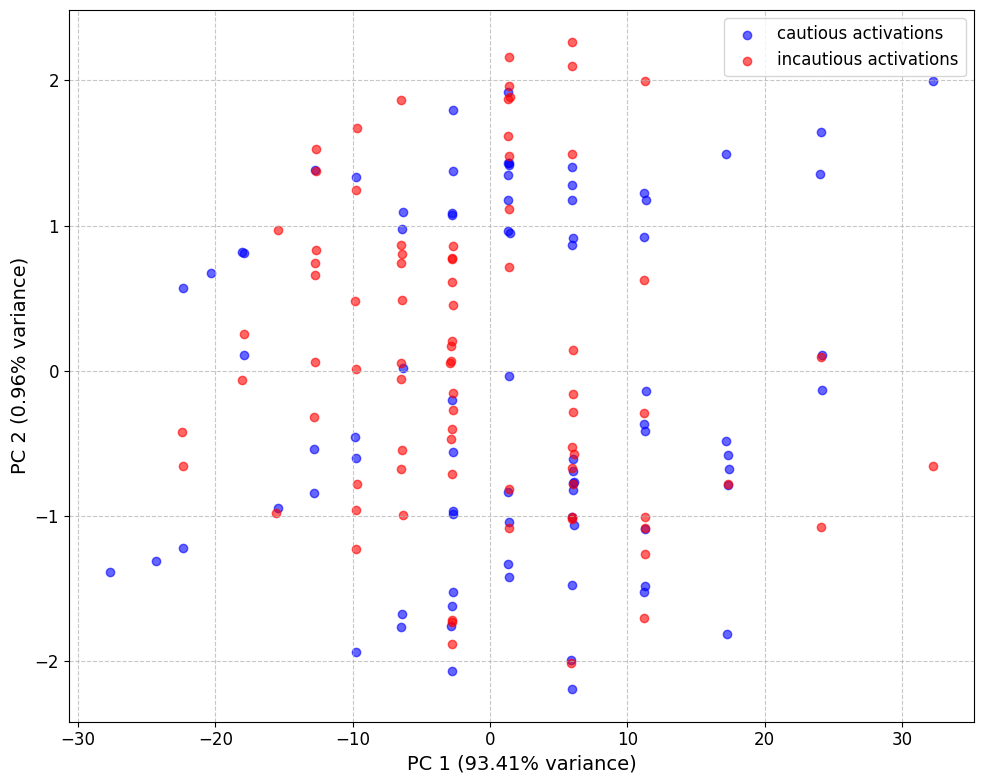


Top features for PC1:
  Feature 788: 0.6055
  Feature 1384: -0.5556
  Feature 4062: -0.5526
  Feature 290: -0.0807
  Feature 2352: -0.0648
  Feature 4055: -0.0272
  Feature 1189: 0.0210
  Feature 2265: -0.0206
  Feature 709: 0.0189
  Feature 2992: -0.0187

Top features for PC2:
  Feature 4055: 0.1425
  Feature 873: 0.0898
  Feature 1189: -0.0884
  Feature 2727: -0.0844
  Feature 2261: 0.0748
  Feature 1565: 0.0725
  Feature 3266: 0.0709
  Feature 1298: 0.0708
  Feature 1296: -0.0699
  Feature 1398: 0.0680


In [3]:
def main():
    ndims = 2
    layers = [17]
    labels = ["cautious activations", "incautious activations"]
    activations_dir = "../activations/prompt/"
    output_dir = "../figures/pca/"
    
    for layer in layers:
        # Load activations
        activations_cautious = load_activations(os.path.join(activations_dir, f"deepseek_layer_{layer}_cautious_activations.npy"))
        activations_noncautious = load_activations(os.path.join(activations_dir, f"deepseek_layer_{layer}_noncautious_activations.npy"))
        
        if activations_cautious is None or activations_noncautious is None:
            print("Failed to load one or both activation files. Exiting.")
            return
        
        # Check dimensions
        if activations_cautious.shape != activations_noncautious.shape:
            print(f"Warning: Activation shapes don't match - {activations_cautious.shape} vs {activations_noncautious.shape}")
        
        # Plot PCA comparison
        result = plot_pca_comparison(
            activations_cautious, 
            activations_noncautious, 
            n_components=ndims,
            labels=labels,
            output_file=os.path.join(output_dir, f"pca_{layer}_activations_pca.png")
        )
        
        # Analyze PCA components if requested
        if result:
            analyze_pca_components(result["pca"])

main()

Loaded activations with shape: (81, 4096)
Loaded activations with shape: (81, 4096)
Explained variance ratio: [0.18414146 0.08482779]
Total explained variance: 0.2690
Saved PCA plot to ../figures/pca/pca_17_activations_cot150.png


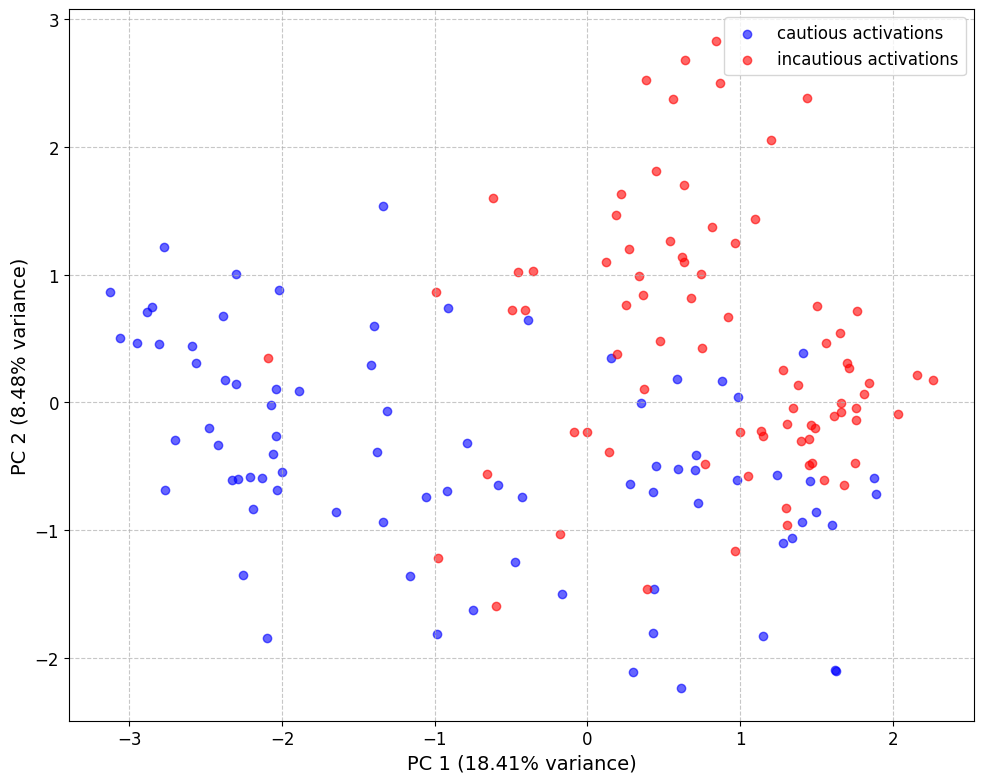


Top features for PC1:
  Feature 1815: 0.1352
  Feature 3881: -0.1287
  Feature 133: -0.1102
  Feature 1189: -0.1092
  Feature 291: -0.0965
  Feature 912: 0.0833
  Feature 568: -0.0830
  Feature 1298: -0.0815
  Feature 866: 0.0710
  Feature 4055: 0.0637

Top features for PC2:
  Feature 325: 0.1076
  Feature 4062: -0.0728
  Feature 2742: -0.0692
  Feature 2613: 0.0649
  Feature 1421: 0.0635
  Feature 2040: 0.0617
  Feature 3183: 0.0562
  Feature 2764: -0.0547
  Feature 3093: 0.0533
  Feature 80: 0.0530


In [11]:
def main():
    ndims = 2
    layers = [17]
    labels = ["cautious activations", "incautious activations"]
    activations_dir = "../activations/cot150/"
    output_dir = "../figures/pca/"
    
    for layer in layers:
        # Load activations
        activations_cautious = load_activations(os.path.join(activations_dir, f"deepseek_layer_{layer}_cautious_activations.npy"))
        activations_noncautious = load_activations(os.path.join(activations_dir, f"deepseek_layer_{layer}_noncautious_activations.npy"))
        
        if activations_cautious is None or activations_noncautious is None:
            print("Failed to load one or both activation files. Exiting.")
            return
        
        # Check dimensions
        if activations_cautious.shape != activations_noncautious.shape:
            print(f"Warning: Activation shapes don't match - {activations_cautious.shape} vs {activations_noncautious.shape}")
        
        # Plot PCA comparison
        result = plot_pca_comparison(
            activations_cautious, 
            activations_noncautious, 
            n_components=ndims,
            labels=labels,
            output_file=os.path.join(output_dir, f"pca_{layer}_activations_cot150.png")
        )
        
        # Analyze PCA components if requested
        if result:
            analyze_pca_components(result["pca"])

main()